In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec

D:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
D:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# 数据预处理
data = pd.read_csv(r'D:\25spring\wednesday\2\data2lab-main\datset.csv')
print(data.columns)

Index(['subject_id', 'Count_subj', 'study_id', 'cart_id', 'Healthy_Status',
       'eeg_time ', 'eeg_date ', 'report_0', 'report_1', 'report_2',
       'report_3', 'report_4', 'report_5', 'report_6', 'report_7', 'report_8',
       'report_9', 'report_10', 'report_11', 'report_12', 'report_13',
       'report_14', 'report_15', 'report_16', 'report_17', 'bandwidth',
       'filtering', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end',
       't_end', 'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')


In [3]:
data.head(3)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77


In [4]:
# 2. 数据清理：去除异常值
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
data = data[(data[columns_to_filter] < 2000).all(axis=1)]  # 去除数值超过2000的异常值
data = data[(data['p_onset'] < data['p_end']) & (data['qrs_onset'] < data['qrs_end'])]  # 保证逻辑关系成立

In [5]:
# 3. 文本报告清理与合并
reports = [f'report_{x}' for x in range(18)]
data['report_0'] = data[reports].astype(str).agg(' '.join, axis=1)
data['report_0'] = data['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
data = data.drop(reports[1:], axis=1)

In [6]:
# 4. 使用Word2Vec转换文本报告为数值向量
words = [text.split() for text in data['report_0']]
w2v_model = Word2Vec(words, vector_size=100, window=5, min_count=1)

def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

data['report'] = data['report_0'].apply(lambda x: get_sentence_embedding(x).mean())

In [7]:
data.head(3)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,bandwidth,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,report
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm Possible right atrial abnormality...,0.005-150 Hz,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79,0.030320
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm Possible right atrial abnormality...,0.005-150 Hz,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70,0.030320
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia Normal ECG except for rate,0.005-150 Hz,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77,0.000334


In [8]:
data = data.drop(columns=['subject_id', 'study_id', 'cart_id', 'eeg_time ', 'eeg_date ', 'filtering', 'Count_subj', 'bandwidth', 'report_0','p_onset', 'report'])
data.head(3)

,Healthy_Status,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,0,659,128,170,258,518,81,77,79
1,0,722,124,162,246,504,77,75,70
2,1,600,130,162,244,474,79,72,77


In [9]:
# for col in data.columns:
#     print(f"列 '{col}' 的类型: {data[col].dtype}")
#     # 如果不是数值类型，显示前几个值
#     if data[col].dtype == 'object':
#         print(f"前3个值: {data[col].head(3).values}")

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# 这里我们需要分离特征和标签
X = data.drop('Healthy_Status', axis=1)
y = data['Healthy_Status']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 定义神经网络模型
class HeartDiseaseClassifier(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 512)
        self.layer3 = nn.Linear(512, 128)
        self.layer4 = nn.Linear(128, 32)
        self.layer5 = nn.Linear(32, 2)  # 二分类输出
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.batch_norm4 = nn.BatchNorm1d(32)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        
        x = self.layer4(x)
        return x

In [12]:
# 初始化模型
input_dim = X_train.shape[1]  # 输入特征的维度
model = HeartDiseaseClassifier(input_dim)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 记录训练过程
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 测试模型
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


Epoch [10/500], Train Loss: 0.4337, Train Acc: 76.83%, Test Loss: 0.4149, Test Acc: 77.80%
Epoch [20/500], Train Loss: 0.4160, Train Acc: 77.80%, Test Loss: 0.4008, Test Acc: 78.09%
Epoch [30/500], Train Loss: 0.4121, Train Acc: 77.63%, Test Loss: 0.4043, Test Acc: 78.79%
Epoch [40/500], Train Loss: 0.4135, Train Acc: 78.30%, Test Loss: 0.4021, Test Acc: 78.58%
Epoch [50/500], Train Loss: 0.4082, Train Acc: 78.78%, Test Loss: 0.3959, Test Acc: 79.43%
Epoch [60/500], Train Loss: 0.4076, Train Acc: 78.37%, Test Loss: 0.4137, Test Acc: 78.09%
Epoch [70/500], Train Loss: 0.4011, Train Acc: 78.83%, Test Loss: 0.3968, Test Acc: 78.30%
Epoch [80/500], Train Loss: 0.3991, Train Acc: 79.13%, Test Loss: 0.4070, Test Acc: 78.94%
Epoch [90/500], Train Loss: 0.4026, Train Acc: 78.90%, Test Loss: 0.4193, Test Acc: 77.73%
Epoch [100/500], Train Loss: 0.3997, Train Acc: 78.78%, Test Loss: 0.3989, Test Acc: 78.37%
Epoch [110/500], Train Loss: 0.4011, Train Acc: 78.76%, Test Loss: 0.3952, Test Acc: 78.5

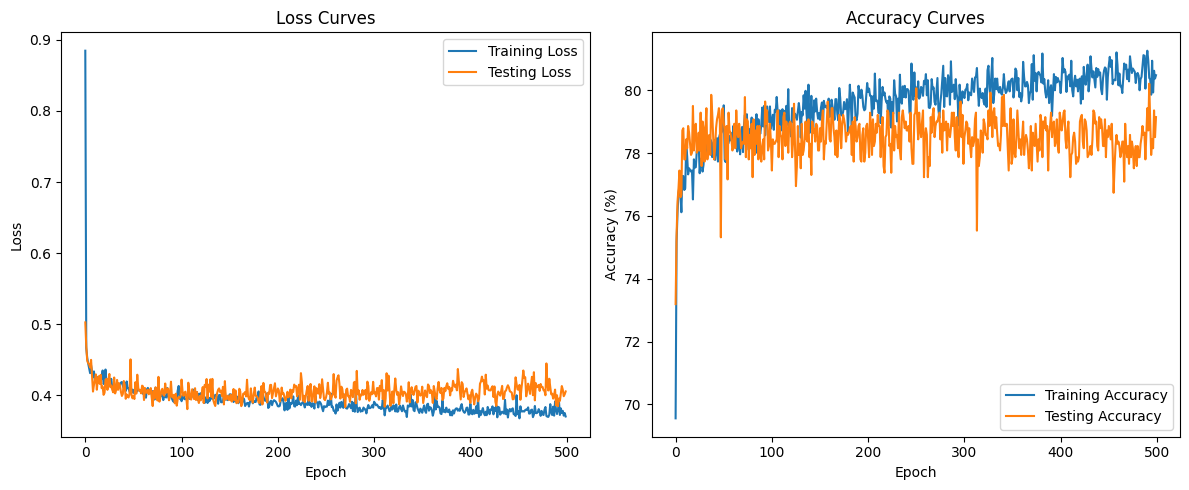

In [13]:
# 绘制训练和测试的损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# 评估模型
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# # 计算混淆矩阵
# cm = confusion_matrix(all_labels, all_predictions)
# f1 = f1_score(all_labels, all_predictions, average='weighted')

# # 打印分类报告
# print('\n分类报告:')
# print(classification_report(all_labels, all_predictions, target_names=['不健康', '健康']))



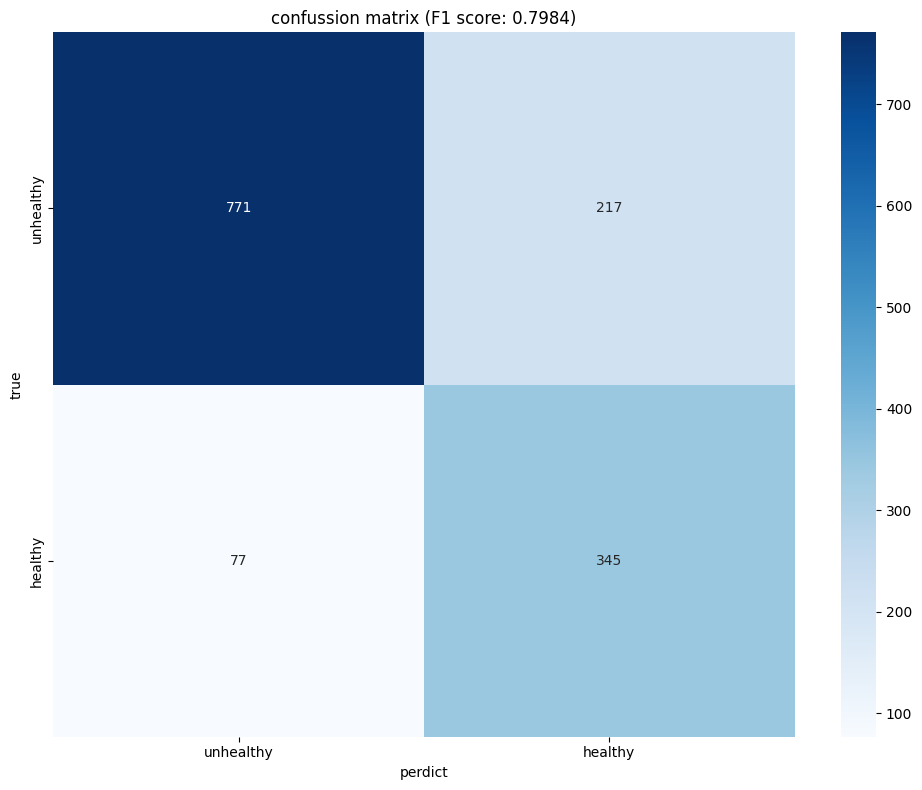

In [14]:
# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['unhealthy', 'healthy'], yticklabels=['unhealthy', 'healthy'])
plt.xlabel('perdict')
plt.ylabel('true')
plt.title(f'confussion matrix (F1 score: {f1:.4f})')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [15]:
# # 特征重要性分析（使用模型的第一层权重作为简单的重要性指标）
# feature_importance = torch.abs(model.layer1.weight).mean(dim=0).cpu().detach().numpy()
# feature_names = X.columns

# # 绘制特征重要性
# plt.figure(figsize=(12, 6))
# plt.bar(feature_names, feature_importance)
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('特征')
# plt.ylabel('重要性')
# plt.title('特征重要性')
# plt.tight_layout()
# plt.savefig('feature_importance.png')
# plt.show()